In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import torch 
import torchvision
from torch import nn
from torchvision import transforms
from torch.nn.functional import softmax

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# ex 1

In [ ]:
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# ex 3

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')

images = [[None]*10]

In [ ]:

im_idx = []
for i in range(10):
    idxs = np.where(np.array(cifar_trainset.targets)==i)[0]
    im_idx.append(idxs[:5])

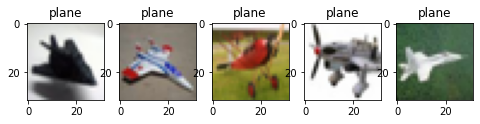

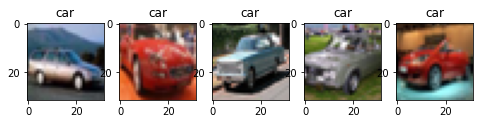

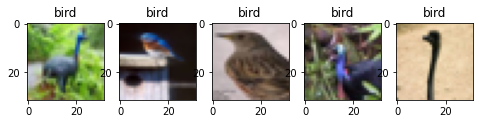

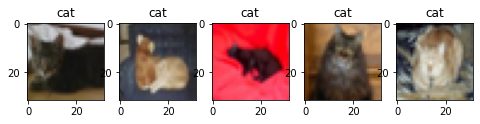

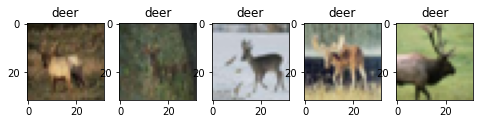

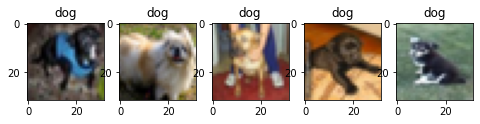

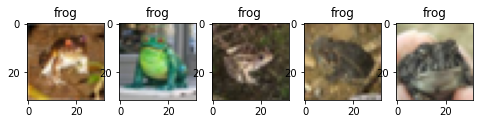

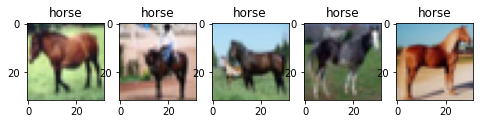

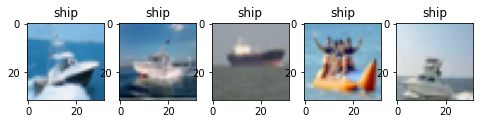

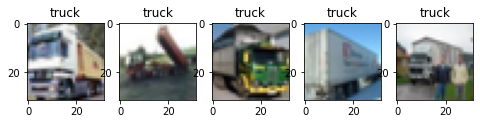

In [ ]:
def plot_classes(idxs, c):
    plt.figure(figsize=(8, 8))
    for i, idx in enumerate(idxs[:5]):
        data, label = cifar_trainset.__getitem__(idx)
        image = np.array(data)
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.title(classes[label])
        
for c, idxs in enumerate(im_idx):
    plot_classes(idxs, c)


# ex 4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
resnet_model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# ex 5

In [ ]:
for layer in resnet_model.named_children():
    print(layer)

('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('relu', ReLU(inplace=True))
('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
('layer1', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kerne

In [ ]:
resnet_model.fc = nn.Linear(512, 10)

# ex 6


In [ ]:

transform = transforms.Compose([
         transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))                                 
    ])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
          cifar_trainset, batch_size=32, shuffle=True,
          pin_memory=True)

test_loader = torch.utils.data.DataLoader(
          cifar_testset, batch_size=1, shuffle=False,
          pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for param in resnet_model.parameters():
    param.requires_grad = False 

for param in resnet_model.fc.parameters():
    param.requires_grad = True
    

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion):

    epoch_loss = []
    total = 0
    correct = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
            
        data = data.to(device)
        labels = labels.to(device)

        preds = model(data)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bach_loss = loss.item()
        epoch_loss.append(bach_loss)


    return epoch_loss



In [ ]:
def train_model( model, train_loader, optimizer, criterion, epochs):

    train_loss = []

    for epoch in range(epochs):
        model.train()      
        
        epoch_loss = train_epoch(model, train_loader, optimizer, criterion)

        loss = np.average(epoch_loss)
        train_loss.append(loss)

        print(f"{epoch} epochs: loss:{loss}")   

    return model, train_loss

In [ ]:
epochs = 10
lr = 0.0001
optimizer = torch.optim.Adam(resnet_model.fc.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
resnet_model = resnet_model.to(device)
resnet_model, train_loss = train_model( resnet_model, train_loader, optimizer, criterion, epochs)

0 epochs: loss:2.0084138461892147
1 epochs: loss:1.7244759946775527
2 epochs: loss:1.6564916059594084
3 epochs: loss:1.624201315454543
4 epochs: loss:1.6019657017402136
5 epochs: loss:1.5951647153666442
6 epochs: loss:1.5786941969387056
7 epochs: loss:1.573476915624915
8 epochs: loss:1.569161260654281
9 epochs: loss:1.5645492950922697


# ex 7 

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    results = []

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            if predictions != y:
                results.append([i, y.cpu().numpy()[0], predictions.cpu().numpy()[0], scores.softmax(dim=1).cpu().numpy()[0].max()])

        print(f" with accuracy {float(num_correct)/float(num_samples):.4f}")

    return results


In [ ]:
results = check_accuracy(test_loader, resnet_model)

 with accuracy 0.4664


# ex 8 

In [ ]:
def sortby(x):
    return x[3]

results_sorted = sorted(results, key=sortby)


In [ ]:
top_ten = results_sorted[-10:]
top_ten.reverse()

# ex 9 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

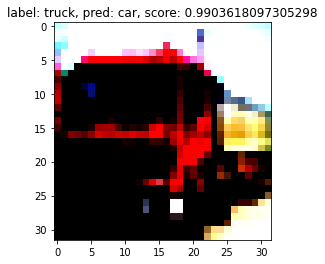

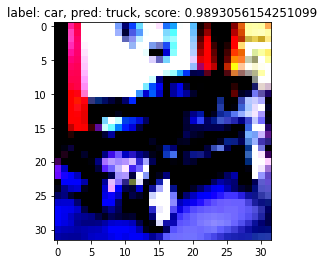

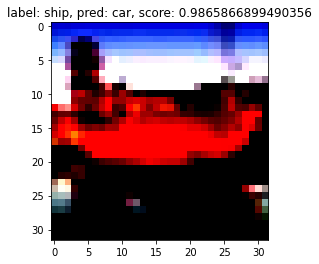

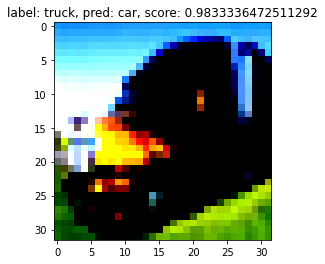

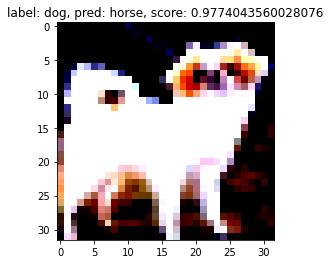

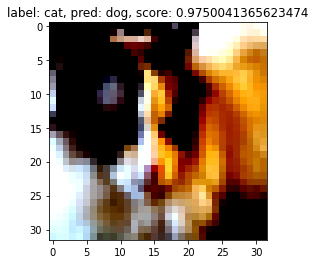

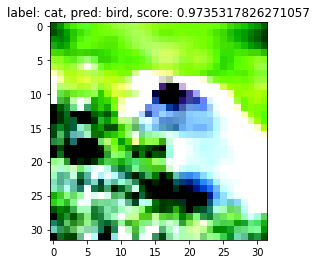

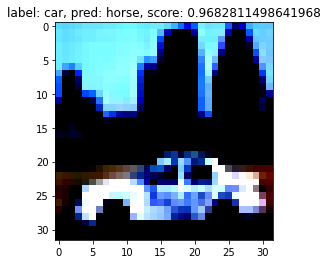

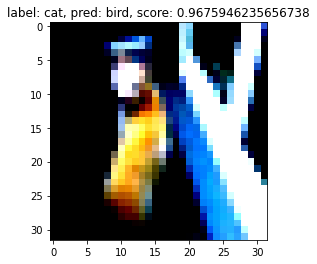

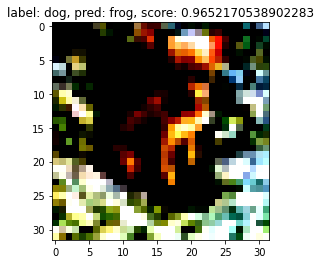

In [ ]:
def plot_error_samples(idx, cl, pred, score):
    plt.figure()
    data, label = cifar_testset.__getitem__(idx)
    image = np.array(data)
    image = np.moveaxis(image, 0, 2)
    plt.imshow(image)
    plt.title(f"label: {classes[cl]}, pred: {classes[pred]}, score: {score}")
        
for idxs in top_ten:
    plot_error_samples( idxs[0], idxs[1], idxs[2], idxs[3])

# ex10 

In [ ]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=2):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        identity = self.bn3(self.downsample(identity))
        x += identity
        x = self.relu(x)
        return x


class model(nn.Module):
    def __init__(self, image_channels, num_classes):
        
        super(model, self).__init__()
        self.in_channels = image_channels
        
        self.resblock1 = Block(image_channels, 64)
        self.resblock2 = Block(64, 128)
        self.resblock3 = Block(128, 256)
        self.relu = nn.ReLU()

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
         
    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    


In [ ]:
my_model = model(3, 10).to(device)
epochs = 10
lr = 0.0001
optimizer = torch.optim.Adam(my_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
my_model, train_loss = train_model( my_model, train_loader, optimizer, criterion, epochs)

0 epochs: loss:1.3470236522527512
1 epochs: loss:0.9585566153834435
2 epochs: loss:0.7694784448036992
3 epochs: loss:0.6184504278199611
4 epochs: loss:0.48933649195628676
5 epochs: loss:0.3724015970224001
6 epochs: loss:0.2814165834773639
7 epochs: loss:0.20321238005172726
8 epochs: loss:0.1553292561606078
9 epochs: loss:0.122900627731028


# ex11

In [ ]:
my_model_results = check_accuracy(test_loader, my_model)

 with accuracy 0.7215
